In [1]:
import torch
import matplotlib.pyplot as plt
import pandas as pd
from gluonts.dataset.pandas import PandasDataset
from gluonts.dataset.split import split
from huggingface_hub import hf_hub_download
from gluonts.dataset.common import ListDataset
from pandas.tseries.offsets import DateOffset

from uni2ts.eval_util.plot import plot_single
from uni2ts.model.moirai import MoiraiForecast, MoiraiModule
import numpy as np
import plotly.graph_objs as go


SIZE = "small"  # model size: choose from {'small', 'base', 'large'}
PDT = 300  # prediction length: any positive integer
CTX = 365 * 5  # Example: five years of data to predict the next three
PSZ = "auto"  # patch size: choose from {"auto", 8, 16, 32, 64, 128}
BSZ = 32  # batch size: any positive integer
TEST = 888  # test set length: any positive integer

In [2]:
# Import the data 
def load_and_prepare_data(file_path):
    """
    Load energy prices data from a CSV file, ensure chronological order, and convert 'Date' to datetime.
    """
    df = pd.read_csv(file_path, parse_dates=['date'])
    df['date'] = pd.to_datetime(df['date'])
    df.sort_values('date', inplace=True)
    df.set_index('date', inplace=True)
    df = pd.DataFrame(df)
    return df

In [3]:
# Import the data
df = load_and_prepare_data('../../data/Final_data/final_data.csv')

# Reset the index
df = df.reset_index()

In [4]:
# Convert 'date' column to datetime
df['date'] = pd.to_datetime(df['date'])

# Set the 'date' column as the index
df.set_index('date', inplace=True)

# Ensure the DataFrame is sorted by the index
df.sort_index(inplace=True)

# setting daily frequency
df = df.asfreq('D')


In [5]:
# Checking the frequency of the dataset
print("Original Frequency:", df.index.freq)

# If the frequency is None or not what you expect, you can set it:
if df.index.freq is None:
    df = df.asfreq('D')  # 'D' for daily frequency, adjust as necessary

# Check again after setting the frequency
print("Adjusted Frequency:", df.index.freq)

# Handling missing values after resampling
df = df.fillna(method='ffill')  # forward fill; you can also use 'bfill' or interpolation




Original Frequency: <Day>
Adjusted Frequency: <Day>


/var/folders/8w/b_0gc01d70g6h4k62sb7ytyw0000gn/T/ipykernel_80323/3444548334.py:12: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')  # forward fill; you can also use 'bfill' or interpolation


### Creating a GluonTs data frame

In [6]:
# Define the frequency of the dataset
freq = "D"  # Daily frequency, adjust this based on your data's actual frequency

# Create the GluonTS dataset focusing only on the Day_ahead_price column
gluon_ds = ListDataset(
    [{"start": df.index[0], "target": df['Day_ahead_price'].values, "item_id": "day_ahead_price"}],
    freq=freq
)


In [7]:
for entry in gluon_ds:
    print(entry)
    break  # Just print the first entry to verify


{'start': Period('2012-01-01', 'D'), 'target': array([18.1896, 33.8188, 35.0263, ..., 73.8362, 71.8213, 63.2038],
      dtype=float32), 'item_id': 'day_ahead_price'}


In [8]:
import pandas as pd
from gluonts.dataset.common import ListDataset

# Calculate the split point
split_point = int(len(df) * 0.8)

# Split the DataFrame into training and testing
train_df = df.iloc[:split_point]
test_df = df.iloc[split_point:]

# Now create GluonTS datasets from these DataFrames
train_ds = ListDataset(
    [{"start": train_df.index[0], "target": train_df['Day_ahead_price'].values}],
    freq=freq
)

test_ds = ListDataset(
    [{"start": test_df.index[0], "target": test_df['Day_ahead_price'].values}],
    freq=freq
)



In [9]:
train_ds

[{'start': Period('2012-01-01', 'D'),
  'target': array([ 18.1896,  33.8188,  35.0263, ..., 149.8921, 145.9767,  73.1596],
        dtype=float32)}]

In [10]:
test_ds

[{'start': Period('2021-09-24', 'D'),
  'target': array([ 1.089808e+02,  1.275875e+02,  1.257175e+02,  1.432183e+02,
          1.550863e+02,  1.333138e+02,  1.125708e+02,  1.003267e+02,
          1.040558e+02,  4.096290e+01,  1.581208e+02,  1.597288e+02,
          1.841237e+02,  3.025262e+02,  2.038929e+02,  1.394917e+02,
          1.443367e+02,  1.678408e+02,  1.674317e+02,  1.882429e+02,
          1.678092e+02,  1.166517e+02,  1.567767e+02,  1.421558e+02,
          1.897217e+02,  1.534550e+02,  6.011040e+01,  6.150330e+01,
          7.187420e+01,  1.393771e+02,  9.941130e+01,  1.736496e+02,
          1.780150e+02,  1.438367e+02,  1.535396e+02,  1.129733e+02,
          8.415330e+01,  6.144640e+01,  9.548620e+01,  2.041087e+02,
          1.931379e+02,  1.721108e+02,  1.600883e+02,  7.675670e+01,
          3.540750e+01,  1.774133e+02,  1.631362e+02,  1.762596e+02,
          1.904267e+02,  1.668963e+02,  1.568975e+02,  1.692954e+02,
          2.279579e+02,  2.374650e+02,  1.805992e+02,  

## Morai Implementation according to HuggingFace

In [11]:
import pandas as pd
from gluonts.dataset.common import ListDataset
import numpy as np

# Load and prepare your DataFrame (assuming df is already defined and loaded with a datetime index)
target_column = 'Day_ahead_price'

# Split the data 80/20
split_index = int(len(df) * 0.8)
train_df = df.iloc[:split_index]
test_df = df.iloc[split_index:]

# Create GluonTS datasets
train_ds = ListDataset([{
    "target": train_df["Day_ahead_price"].values,  # Your target variable
    "start": train_df.index[0]
}], freq='D')

test_ds = ListDataset([{
    "target": test_df["Day_ahead_price"].values,
    "start": test_df.index[0]
}], freq='D')

In [12]:
# Give me the first and the last day of the test dataset
for entry in test_ds:
    print(entry['start'])
    print(entry['start'] + len(entry['target']) - 1)

# COunt the number of days in between 
len(test_df)

2021-09-24
2024-02-29


889

### Model initialization

In [13]:
from uni2ts.model.moirai import MoiraiForecast, MoiraiModule

# Assuming SIZE, PDT, CTX, PSZ, and BSZ are defined as before
model = MoiraiForecast(
    module=MoiraiModule.from_pretrained(f"Salesforce/moirai-1.0-R-{SIZE}"),
    prediction_length=100,
    context_length=CTX,
    patch_size=PSZ,
    num_samples=100,
    target_dim=1,  # Only one target dimension
    feat_dynamic_real_dim=0,  # Set to 0 if no dynamic real features are available
    past_feat_dynamic_real_dim=0  # Adjust based on your data structure
)


ValueError: x and y must have same first dimension, but have shapes (888,) and (889,)

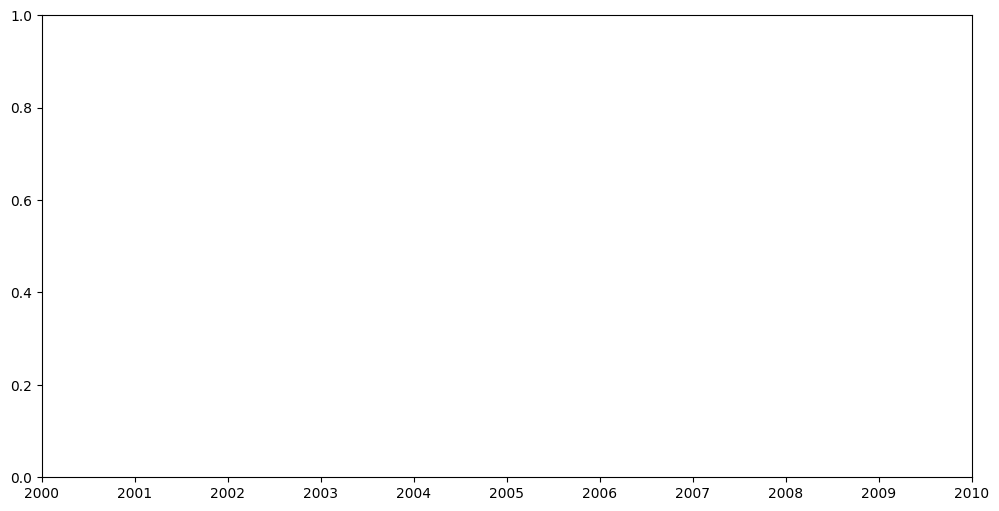

In [ ]:
predictor = model.create_predictor(batch_size=BSZ)
# Forecast generation
forecasts = predictor.predict(test_data.input)

# Generating date ranges for plotting, ensure the length is derived from mean_forecast
forecast_dates = pd.date_range(start=start_date, periods=len(mean_forecast), freq='D')
actual_dates = pd.date_range(start=start_date, periods=len(test_entry['target'])-1, freq='D')

# Plot results
for test_entry, forecast in zip(test_ds, forecasts):
    pd.plotting.register_matplotlib_converters()  # Ensure compatibility
    plt.figure(figsize=(12, 6))
    plt.plot(actual_dates, test_entry['target'], label='Actual', marker='o')
    plt.plot(forecast_dates, mean_forecast, label='Forecast', linestyle='--', marker='x')
    plt.title('Forecast vs Actuals')
    plt.xlabel('Date')
    plt.ylabel('Day Ahead Price')
    plt.legend()
    plt.show()


## Approach with Pandas ListDataset

Step 1: Correctly Structuring Dataset

In [75]:
import pandas as pd
from gluonts.dataset.common import ListDataset

# Assume 'df' is your DataFrame and it's indexed by datetime
# Let's assume 'df' is already loaded and indexed by 'date' as a datetime type
target_column = 'Day_ahead_price'
dynamic_features = df.columns.drop(target_column)  # This excludes the target column from the features

data_dict = {
    'target': df[target_column].values,  # target must be a 1D array
    'start': df.index[0],  # the start date of the series
    'feat_dynamic_real': df[dynamic_features].values.T  # transpose to align with expected shape
}

# Create the GluonTS dataset
dataset = ListDataset([data_dict], freq='D')  # 'D' for daily frequency

In [76]:
dataset

[{'target': array([18.1896, 33.8188, 35.0263, ..., 73.8362, 71.8213, 63.2038],
        dtype=float32),
  'start': Period('2012-01-01', 'D'),
  'feat_dynamic_real': array([[   6.   ,    6.   ,    6.   , ...,  947.   ,  947.   ,  963.   ],
         [  98.605,   98.605,   98.605, ...,  124.989,  125.068,  124.721],
         [ 108.454,  222.656,  162.204, ...,  103.379,   93.416,   69.303],
         ...,
         [ 235.467,  231.772,  504.484, ...,  131.761,   76.355,  352.238],
         [   4.95 ,    5.   ,    7.77 , ...,    3.11 ,    2.46 ,    3.48 ],
         [  54.662,  -64.477,  -35.078, ..., -209.332, -206.956,  -59.574]],
        dtype=float32)}]

In [77]:
# Assuming 'dataset' is your ListDataset or similar
for entry in dataset:
    print(entry.keys())  # This will print the keys available in each entry


dict_keys(['target', 'start', 'feat_dynamic_real'])


In [78]:
# Access the first dictionary in the list
data = dataset[0]

# Number of data points
num_data_points = len(data['target'])
train_size = int(num_data_points * 0.8)

# Split the target array and dynamic features
train_target = data['target'][:train_size]
test_target = data['target'][train_size:]

train_feat_dynamic_real = data['feat_dynamic_real'][:, :train_size]
test_feat_dynamic_real = data['feat_dynamic_real'][:, train_size:]



# Assuming `data['start']` is a Period, you need to first convert it to a timestamp if it's not already one.
start_date = pd.Timestamp(data['start'].start_time)  # Convert Period to timestamp

train_data = ListDataset(
    [{'start': start_date, 'target': train_target, 'feat_dynamic_real': train_feat_dynamic_real}],
    freq="D"
)

test_start_date = start_date + DateOffset(days=train_size)  # Offset by the size of the training set

test_data = ListDataset(
    [{'start': test_start_date, 'target': test_target, 'feat_dynamic_real': test_feat_dynamic_real}],
    freq="D"
)


In [79]:
train_data

[{'start': Period('2012-01-01', 'D'),
  'target': array([ 18.1896,  33.8188,  35.0263, ..., 149.8921, 145.9767,  73.1596],
        dtype=float32),
  'feat_dynamic_real': array([[   6.   ,    6.   ,    6.   , ..., 1121.   , 1121.   , 1121.   ],
         [  98.605,   98.605,   98.605, ...,  109.129,  109.571,  107.471],
         [ 108.454,  222.656,  162.204, ...,  246.619,  221.411,   99.219],
         ...,
         [ 235.467,  231.772,  504.484, ...,  116.275,  143.816,  557.145],
         [   4.95 ,    5.   ,    7.77 , ...,    2.58 ,    2.75 ,    4.88 ],
         [  54.662,  -64.477,  -35.078, ...,   23.889,   60.668,  146.872]],
        dtype=float32)}]

In [80]:
test_data

[{'start': Period('2021-09-24', 'D'),
  'target': array([ 1.089808e+02,  1.275875e+02,  1.257175e+02,  1.432183e+02,
          1.550863e+02,  1.333138e+02,  1.125708e+02,  1.003267e+02,
          1.040558e+02,  4.096290e+01,  1.581208e+02,  1.597288e+02,
          1.841237e+02,  3.025262e+02,  2.038929e+02,  1.394917e+02,
          1.443367e+02,  1.678408e+02,  1.674317e+02,  1.882429e+02,
          1.678092e+02,  1.166517e+02,  1.567767e+02,  1.421558e+02,
          1.897217e+02,  1.534550e+02,  6.011040e+01,  6.150330e+01,
          7.187420e+01,  1.393771e+02,  9.941130e+01,  1.736496e+02,
          1.780150e+02,  1.438367e+02,  1.535396e+02,  1.129733e+02,
          8.415330e+01,  6.144640e+01,  9.548620e+01,  2.041087e+02,
          1.931379e+02,  1.721108e+02,  1.600883e+02,  7.675670e+01,
          3.540750e+01,  1.774133e+02,  1.631362e+02,  1.762596e+02,
          1.904267e+02,  1.668963e+02,  1.568975e+02,  1.692954e+02,
          2.279579e+02,  2.374650e+02,  1.805992e+02,  

Step 2: Adjust Model Configuration

In [94]:
SIZE = "small"  # example size, choose as appropriate: small, base, large
PDT = 888  # example prediction length
CTX = 900  # example context length
PSZ = "auto"  # example patch size
BSZ = 32  # example batch size

# Assuming 'training_data' is your dataset variable from above
num_feat_dynamic_real = len(df.columns) - 1  # Subtract 1 for the target column

# Prepare pre-trained model
model = MoiraiForecast(
    module=MoiraiModule.from_pretrained(f"Salesforce/moirai-1.0-R-{SIZE}"),
    prediction_length=PDT,
    context_length=CTX,
    patch_size=PSZ,
    num_samples=100,
    target_dim=1,  # target is one-dimensional
    feat_dynamic_real_dim=num_feat_dynamic_real,  # number of dynamic real features
    past_feat_dynamic_real_dim=0  # assuming all dynamic features are also past features
)

# Create predictor
predictor = model.create_predictor(batch_size=BSZ)

# Make predictions
forecasts = predictor.predict(train_data)


In [95]:
forecasts

<generator object PyTorchPredictor.predict at 0x341f90040>

Step 3: Accessing and Using the Forecasts

In [96]:
for test_entry, forecast in zip(train_data, forecasts):
    print("Target:", test_entry['target'])  # Should print actual target values
    print("Forecast Mean:", forecast.mean)  # Should print forecast mean values
    print("Forecast Quantiles:", forecast.quantile(0.1), forecast.quantile(0.9))  # Check quantiles


Target: [ 18.1896  33.8188  35.0263 ... 149.8921 145.9767  73.1596]
Forecast Mean: [ 95.4427    95.606735  96.46597  105.79963  107.8725    94.90193
  97.82093   94.641556  92.80627   97.220695  92.32515   92.20731
  95.73648   88.94609   91.28219   88.94713   95.90788  100.824745
  94.068535  98.625305  87.82144  101.009705  91.2808    84.75613
  86.864426  91.33897   91.23369   98.016525  87.09666  102.29534
  92.34407   95.241066  91.32977   86.6858    78.896286  94.31767
  95.35962   87.793915  90.456184  92.715324  81.194916  86.59463
  90.72291   85.73821   85.46069   86.115746  97.19417   88.49781
  82.86049   77.85361   84.96897   78.977005  89.407646  81.6203
  78.90037   81.70107   92.64443   82.10098   84.40627   87.30004
  90.731926  84.34591   83.40841   88.00833   77.91552   84.63061
  89.91455   85.61715   96.2266    93.6497    96.19034   88.49798
  89.54681   92.78998   79.42452   85.92778   77.940125  95.091805
 101.10962   79.16399   80.34381   88.468254  83.705284  9

In [99]:
# Assuming 'train_data' is your input dataset
for entry in train_data:
    print("Start Date:", entry['start'])
    print("Target Sample:", entry['target'][:5])
    if 'feat_dynamic_real' in entry:
        print("Dynamic Features Sample:", entry['feat_dynamic_real'][:, :5])


Start Date: 2012-01-01
Target Sample: [18.1896 33.8188 35.0263 32.1633 20.35  ]
Dynamic Features Sample: [[  6.      6.      6.      6.      6.   ]
 [ 98.605  98.605  98.605  98.605  98.605]
 [108.454 222.656 162.204 189.633 175.733]
 [ 51.011  51.862  48.851  47.101  45.854]
 [325.337 343.168 336.773 323.976 327.502]
 [188.811 229.293 241.297 252.289 259.018]
 [250.979 258.671 271.495 270.613 287.555]
 [ 98.99   99.39   99.79  102.48  103.24 ]
 [ 54.04   54.166  53.518  52.194  52.179]
 [ 19.314  28.892  21.072  28.3    31.887]
 [  6.263   6.312  24.226  14.157   4.728]
 [ 14.75   15.12   31.88   25.21   13.46 ]
 [ 21.1    20.     20.9    21.4    21.3  ]
 [  8.39    7.41    5.23    4.78    4.23 ]
 [  3.404   3.35    7.292   7.828   8.28 ]
 [235.467 231.772 504.484 541.528 572.819]
 [  4.95    5.      7.77    8.04    9.98 ]
 [ 54.662 -64.477 -35.078  22.924  35.618]]


In [105]:
print(dir(model))

['CHECKPOINT_HYPER_PARAMS_KEY', 'CHECKPOINT_HYPER_PARAMS_NAME', 'CHECKPOINT_HYPER_PARAMS_TYPE', 'T_destination', '_LightningModule__check_allowed', '_LightningModule__check_not_nested', '_LightningModule__to_tensor', '__annotations__', '__call__', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattr__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__jit_unused_properties__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__setstate__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_apply', '_apply_batch_transfer_handler', '_automatic_optimization', '_backward_hooks', '_backward_pre_hooks', '_buffers', '_call_batch_hook', '_call_impl', '_compiled_call_impl', '_compiler_ctx', '_convert', '_current_fx_name', '_device', '_device_mesh', '_dtype', '_example_input_array', '_fabric', '_fabric_optimizers', '_format

In [104]:
# Example of a minimal test case
test_data = {
    'start': pd.Period('2020-01-01', freq='D'),
    'target': np.array([10, 15, 20, 25, 30]),
    'feat_dynamic_real': np.array([[1, 2, 3, 4, 5]])
}
test_dataset = ListDataset([test_data], freq='D')
forecasts = list(model.predict(test_data))

if forecasts:
    print("Test forecast successful.")
else:
    print("Test forecast failed.")


AttributeError: 'MoiraiForecast' object has no attribute 'predict'

In [97]:
# Ensure train_data is not empty
print("Number of entries:", len(train_data))

# Try to fetch one forecast to see if it generates
try:
    first_forecast = next(iter(forecasts))
    print("First forecast mean:", first_forecast.mean)
except StopIteration:
    print("No forecasts available.")
except Exception as e:
    print("Error fetching forecasts:", e)


Number of entries: 1
No forecasts available.


In [98]:
forecasts = list(forecasts)  # Convert generator to list to reuse and check length
print("Number of forecasts:", len(forecasts))

# Then you can plot as before:
for test_entry, forecast in zip(train_data, forecasts):
    print("Plotting data for entry starting:", test_entry['start'])
    prediction_intervals = (forecast.quantile(0.1), forecast.quantile(0.9))
    plt.figure(figsize=(10, 6))
    if len(test_entry['target']) > 0 and len(forecast.mean) > 0:
        plt.plot(test_entry['target'], label='Actual')
        plt.plot(forecast.mean, label='Forecast')
        plt.fill_between(range(len(forecast.mean)), prediction_intervals[0], prediction_intervals[1], color='b', alpha=0.2)
        plt.legend()
        plt.title(f"Forecast starting {test_entry['start']}")
        plt.show()
    else:
        print("No data to plot for entry starting:", test_entry['start'])


Number of forecasts: 0


Handling Forecast Outputs

In [91]:
import matplotlib.pyplot as plt

# Debugging: Check data directly
print("Number of entries:", len(train_data))
print("Number of forecasts:", len(forecasts))

# Example of plotting the first forecast
for test_entry, forecast in zip(train_data, forecasts):
    print("Plotting data for entry starting:", test_entry['start'])
    prediction_intervals = (forecast.quantile(0.1), forecast.quantile(0.9))
    plt.figure(figsize=(10, 6))
    if len(test_entry['target']) > 0 and len(forecast.mean) > 0:  # Ensure there is data to plot
        plt.plot(test_entry['target'], label='Actual')
        plt.plot(forecast.mean, label='Forecast')
        plt.fill_between(range(len(forecast.mean)), prediction_intervals[0], prediction_intervals[1], color='b', alpha=0.2)
        plt.legend()
        plt.title(f"Forecast starting {test_entry['start']}")
        plt.show()
    else:
        print("No data to plot for entry starting:", test_entry['start'])
    break  # Remove this to plot for all series


Number of entries: 1


TypeError: object of type 'generator' has no len()

## Approach with PandasDataset

In [15]:
df_gluonTS = PandasDataset(dict(df), freq='D')

In [16]:
df_gluonTS

PandasDataset<size=19, freq=D, num_feat_dynamic_real=0, num_past_feat_dynamic_real=0, num_feat_static_real=0, num_feat_static_cat=0, static_cardinalities=[]>

In [17]:
# Checking the first few entries to ensure they are correctly formatted
for entry in df_gluonTS:
    print(entry)
    break  # Just print the first entry for checking


{'start': Period('2012-01-01', 'D'), 'target': array([18.1896, 33.8188, 35.0263, ..., 73.8362, 71.8213, 63.2038]), 'item_id': 'Day_ahead_price'}


## Morai implementation

In [126]:
# Define constants
TEST = 888  # Length of the test set
PDT = 100  # Prediction length
CTX = 500  # Context length

# Split into train/test set
train, test_template = split(df_gluonTS, offset=-TEST)

# Adjust the window generation so that it only uses data within the test period
# Ensure that the rolling windows don't overlap with the training data
test_data = test_template.generate_instances(
    prediction_length=PDT,
    windows=1,  # Limit to only one window to prevent overlap
    distance=PDT,
)

# Prepare the model
model = MoiraiForecast(
    module=MoiraiModule.from_pretrained(f"Salesforce/moirai-1.0-R-{SIZE}"),
    prediction_length=PDT,
    context_length=CTX,
    patch_size="auto",
    num_samples=100,
    target_dim=1,
    feat_dynamic_real_dim=df_gluonTS.num_feat_dynamic_real,
    past_feat_dynamic_real_dim=df_gluonTS.num_past_feat_dynamic_real,
)

# Create predictor and generate forecasts only for the test period
predictor = model.create_predictor(batch_size=BSZ)
forecasts = predictor.predict(test_data.input)

# Fetching data to plot
input_it = iter(test_data.input)
label_it = iter(test_data.label)
forecast_it = iter(forecasts)

input_example = next(input_it)
forecast_example = next(forecast_it)


# Extract the start date from the test data, converting the Period to a Timestamp
test_start_date = pd.Timestamp(input_example['start'].start_time)

# Create date ranges for the actual test data and the forecast
test_actual_dates = pd.date_range(start=test_start_date, periods=len(input_example['target']), freq='D')
forecast_dates = pd.date_range(start=test_start_date + pd.DateOffset(days=CTX), periods=PDT, freq='D')

# Plotting with Plotly
actual_trace = go.Scatter(x=test_actual_dates, y=input_example['target'], mode='lines', name='Actual Test Data', line=dict(color='blue'))
forecast_trace = go.Scatter(x=forecast_dates, y=forecast_example.mean, mode='lines', name='Forecasted Test Data', line=dict(color='red', dash='dash'))
confidence_trace = go.Scatter(x=forecast_dates, y=forecast_example.quantile(0.9), mode='lines', name='Confidence Interval (10%-90%)', line=dict(color='grey'), fill='tonexty')
confidence_trace_lower = go.Scatter(x=forecast_dates, y=forecast_example.quantile(0.1), mode='lines', fill='tonexty', line=dict(color='grey'), showlegend=False)

layout = go.Layout(title="Test Period: Actual Data vs Forecasted Data", xaxis=dict(title='Date'), yaxis=dict(title='Value'))
fig = go.Figure(data=[actual_trace, confidence_trace_lower, confidence_trace, forecast_trace], layout=layout)
fig.show()
